## Supervised learning assignemtn
##### Name: Daan Steur
##### Studentnumber: 379943
##### Supervisor: Drs. Bart Barnard
##### Course: DSLS Data Science 3: Supervised learning
##### Date: 27th of may

### Prediction of health parameters based on patient informatio. 

#### Assignment 
Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others

#### Background


#### Data
Blood Pressure Data for disease Prediction
Patient_Number
 - Blood_Pressure_Abnormality
 - Level_of_Hemoglobin
 - Genetic_Pedigree_Coefficient
 - Age
 - BMI
 - Sex
 - Pregnancy
 - Smoking
 - Physical_activity
 - salt_content_in_the_diet
 - alcohol_consumption_per_day
 - Level_of_Stress
 - Chronic_kidney_disease
 - Adrenal_and_thyroid_disorders

Data & packages

In [1]:
# load packages
# base
import pandas as pd
import numpy as np
import collections
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
# stats
import scipy.stats as stats
import statsmodels.api as sm
from exploration import *
# Modeling
from sklearn import linear_model, metrics, tree, preprocessing
from sklearn.linear_model import LinearRegression
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report

In [2]:
# load data
data = pd.read_csv("data.csv")
# drop parient ids
data.drop(['Patient_Number'], axis=1, inplace=True)
# reoreder columns
data = data[["Blood_Pressure_Abnormality",
            "Chronic_kidney_disease",
             "Adrenal_and_thyroid_disorders",
             "Level_of_Hemoglobin",
             "Genetic_Pedigree_Coefficient",
             "Age",
             "BMI",
             "Sex",
             "Pregnancy",
             "Smoking",
             "Physical_activity",
             "salt_content_in_the_diet",
             "alcohol_consumption_per_day",
             "Level_of_Stress",
]]
data["Sex"] =  data["Sex"].replace({1: "male", 0: "female"})
data["Chronic_kidney_disease"] =  data["Chronic_kidney_disease"].replace({1: "diseased", 0: "healthy"})
data["Adrenal_and_thyroid_disorders"] =  data["Adrenal_and_thyroid_disorders"].replace({1: "diseased", 0: "healthy"})
data["Blood_Pressure_Abnormality"] =  data["Blood_Pressure_Abnormality"].replace({1: "diseased", 0: "healthy"})
data["Smoking"] =  data["Smoking"].replace({1: "yes", 0: "no"})
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
0,diseased,diseased,diseased,11.28,0.90,34,23,male,1.0,no,45961,48071,NaN,2
1,healthy,healthy,healthy,9.75,0.23,54,33,male,NaN,no,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,NaN,no,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,NaN,no,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,NaN,no,15619,49644,397.0,2


Data Exploration (EDA)

In [18]:
# overview of data
exploration.data_exploration_csv("data.csv")
exploration.Categorical_Variables_csv("data.csv")

exploration.violin("Genetic_Pedigree_Coefficient", data)
exploration.violin("Age", data)
exploration.violin("Level_of_Hemoglobin", data)
exploration.violin("BMI", data)

c:\Users\31613\Desktop\Git repositories\DSLS-DS3-Machine-learning\Supervised-learning\exploration.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Continuous variables, descriptive statistics


                             N Obs    N Missing    N Valid    % Complete    N Unique      Mean        SD    Median       MAD    Min       Max    Skewness    Kurtosis  CV
-------------------------  -------  -----------  ---------  ------------  ----------  --------  --------  --------  --------  -----  --------  ----------  ----------  ----
Age                           2000            0       2000         100            58     46.56     17.11     46        22.24   18       75           0.02       -1.25  0.37
alcohol_consumption_per_d     2000          242       1758          87.9         488    251.01    143.65    250       186.81    0      499          -0.01       -1.22
BMI                           2000            0       2000         100            41     30.08     11.76     30        14.83   10       50          -0.02       -1.18  0.39
Genetic_Pedigree_Coeffici     2000           92       1908          95.4         101      0.49      0.29      0.49      0.37    0        1          

AttributeError: type object 'exploration' has no attribute 'violin'

In [4]:
# drop rows with na values
data = data.dropna(subset=["Genetic_Pedigree_Coefficient"])

<AxesSubplot:>

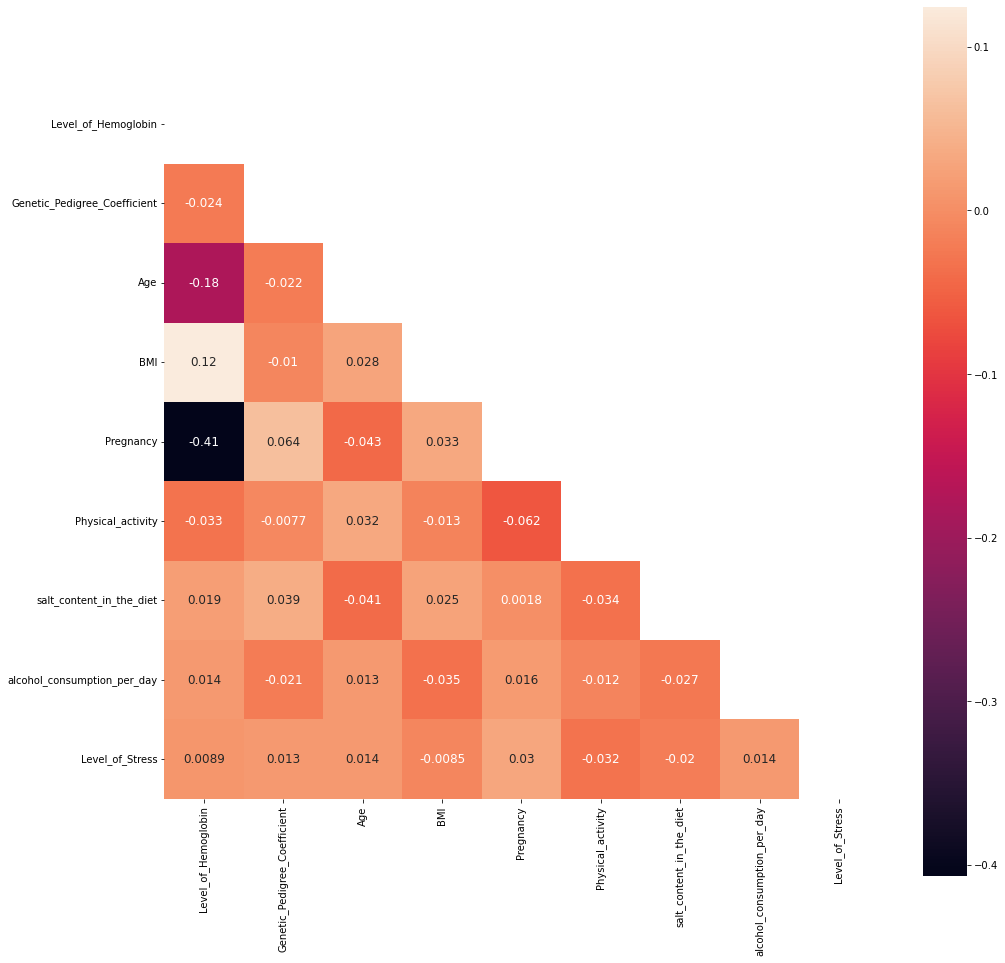

In [5]:
# Calculate correlation between each pair of variable
corr_matrix=data.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 12}, square=True, mask=mask)

### model selection

In [6]:
data.head()

,Blood_Pressure_Abnormality,Chronic_kidney_disease,Adrenal_and_thyroid_disorders,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress
0,diseased,diseased,diseased,11.28,0.90,34,23,male,1.0,no,45961,48071,NaN,2
1,healthy,healthy,healthy,9.75,0.23,54,33,male,NaN,no,26106,25333,205.0,3
2,diseased,diseased,healthy,10.79,0.91,70,49,female,NaN,no,9995,29465,67.0,2
3,healthy,diseased,healthy,11.00,0.43,71,50,female,NaN,no,10635,7439,242.0,1
4,diseased,healthy,healthy,14.17,0.83,52,19,female,NaN,no,15619,49644,397.0,2


In [7]:
# organise data
label_names = ['Blood_Pressure_Abnormality']
labels = data[label_names].to_numpy()
feature_names = ['Genetic_Pedigree_Coefficient', 'Age', 'BMI','Level_of_Stress']
features = data[feature_names].to_numpy()

print(label_names)
print(labels[0])
print(feature_names[0])
print(features[0])

train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)


['Blood_Pressure_Abnormality']
['diseased']
Genetic_Pedigree_Coefficient
[ 0.9 34.  23.   2. ]


### Naïve Bayes Classifier
Naïve Bayes is a classification technique used to build classifier using the Bayes theorem. The assumption is that the predictors are independent. In simple words, it assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature

In [8]:
# naive base model
gnb = GaussianNB()
model = gnb.fit(train, train_labels)
preds = gnb.predict(test)
print(preds[0:25])

print(accuracy_score(test_labels,preds))
confusion_matrix = confusion_matrix(test_labels, preds)
print(confusion_matrix)
print(classification_report(test_labels, preds))


['diseased' 'diseased' 'healthy' 'diseased' 'diseased' 'healthy'
 'diseased' 'diseased' 'diseased' 'healthy' 'healthy' 'diseased' 'healthy'
 'healthy' 'diseased' 'diseased' 'diseased' 'diseased' 'healthy' 'healthy'
 'healthy' 'healthy' 'diseased' 'diseased' 'diseased']
0.7329842931937173
[[142  43]
 [ 59 138]]
              precision    recall  f1-score   support

    diseased       0.71      0.77      0.74       185
     healthy       0.76      0.70      0.73       197

    accuracy                           0.73       382
   macro avg       0.73      0.73      0.73       382
weighted avg       0.74      0.73      0.73       382



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Logistic Regression
Basically, logistic regression model is one of the members of supervised classification algorithm family. Logistic regression measures the relationship between dependent variables and independent variables by estimating the probabilities using a logistic function.

In [9]:
# Logistic Regression
lorm = linear_model.LogisticRegression()
model = lorm.fit(train, train_labels)
preds = lorm.predict(test)
print(preds[0:25])
print(accuracy_score(test_labels,preds))


['healthy' 'healthy' 'diseased' 'diseased' 'diseased' 'diseased' 'healthy'
 'diseased' 'diseased' 'diseased' 'diseased' 'healthy' 'diseased'
 'diseased' 'healthy' 'healthy' 'diseased' 'diseased' 'healthy' 'healthy'
 'healthy' 'healthy' 'healthy' 'diseased' 'healthy']
0.4816753926701571


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Support Vector Machines
Basically, Support vector machine (SVM) is a supervised machine learning algorithm that can be used for both regression and classification. The main concept of SVM is to plot each data item as a point in n-dimensional space with the value of each feature being the value of a particular coordinate. Here n would be the features we would have.

In [10]:
svm = SVC()
model = svm.fit(train, train_labels)
preds = svm.predict(test)
print(preds[0:25])
print(accuracy_score(test_labels,preds))


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['healthy' 'healthy' 'diseased' 'diseased' 'diseased' 'diseased' 'healthy'
 'diseased' 'healthy' 'diseased' 'healthy' 'healthy' 'diseased' 'diseased'
 'healthy' 'diseased' 'healthy' 'diseased' 'healthy' 'healthy' 'diseased'
 'healthy' 'healthy' 'diseased' 'healthy']
0.5052356020942408


#### Decision Tree Classifier
A decision tree is basically a binary tree flowchart where each node splits a group of observations according to some feature variable

#### Stacking models

>lr 0.866 (0.029)
>knn 0.931 (0.025)
>cart 0.827 (0.045)
>svm 0.957 (0.020)
>bayes 0.833 (0.031)


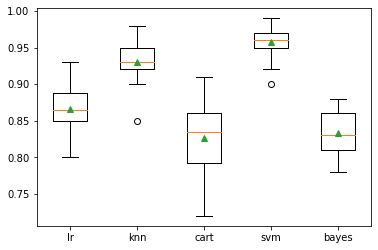

In [11]:
# compare standalone models for binary classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()